### **Computer Vision Project 2 - Ashok Shanmuga Sundaram** 

## **PART-1 - Objective:**
The objective is to build a face detection model from training images and to predict the boundaries around the face in a given image


### **1.0 Importing the Libraries**

In [28]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [29]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [30]:
import numpy as np
import pandas as pd
from glob import glob
import os
import cv2
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, model_from_json, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense ,Input, ZeroPadding2D, Convolution2D, Activation
from keras.optimizers import Adam ,RMSprop

from keras.applications.mobilenet import MobileNet
from keras.losses import binary_crossentropy
from keras.backend import log, epsilon

### **1.1. Importing Data**


In [31]:
from google.colab import drive

In [32]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [33]:
# Adding path to the folder where dataset files are
project_path = '/content/drive/My Drive/AIML/Projects/CV2/'

In [ ]:
# Loading "images.npy" file which contains images with details of bounding boxes
data = np.load(project_path +'images.npy', allow_pickle = True)

[[[ 23  25  37]
  [ 23  25  37]
  [ 23  25  37]
  ...
  [ 11  11  23]
  [ 11  11  23]
  [ 11  11  23]]

 [[ 22  24  36]
  [ 22  24  36]
  [ 21  23  35]
  ...
  [ 11  11  23]
  [ 11  11  23]
  [ 10  10  22]]

 [[ 20  22  34]
  [ 20  22  34]
  [ 19  21  33]
  ...
  [ 10  10  22]
  [  9   9  21]
  [  9   9  21]]

 ...

 [[ 85  92 102]
  [ 85  92 102]
  [ 85  92 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 83  92 101]
  [ 84  93 102]
  [ 84  93 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 83  92 101]
  [ 84  93 102]
  [ 84  93 102]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


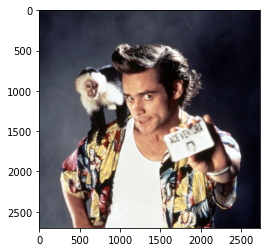

In [ ]:
# Showing the image loaded
print(data[90][0])
plt.imshow(data[90][0])

In [ ]:
# Printing Mask
data[90][1]

[{'imageHeight': 2700,
  'imageWidth': 2741,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3422982885085575, 'y': 0.24648469809760132},
   {'x': 0.634881825590872, 'y': 0.5798180314309347}]}]

In [ ]:
# Setting image width and height
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### **1.2. Creating features (images) and labels (mask) using the training data**
*   Images are stored in "X_train" array
*   Masks are stored in "masks" array

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [ ]:
# Printing shapes of "X_train" and "masks" arrays
print('Shape of X_train: ', X_train.shape)
print('Shape of mask array: ', masks.shape)

Shape of X_train:  (409, 224, 224, 3)
Shape of mask array:  (409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.83529413 -0.72549021 -0.65490198]
  [-0.82745099 -0.70980394 -0.63921571]
  [-0.81176472 -0.68627453 -0.62352943]
  ...
  [-0.87450981 -0.81960785 -0.77254903]
  [-0.87450981 -0.81960785 -0.75686276]
  [-0.86666667 -0.79607844 -0.73333335]]

 [[-0.8509804  -0.7019608  -0.65490198]
  [-0.8509804  -0.7019608  -0.65490198]
  [-0.83529413 -0.68627453 -0.63921571]
  ...
  [-0.86666667 -0.81176472 -0.7647059 ]
  [-0.84313726 -0.78823531 -0.72549021]
  [-0.83529413 -0.7647059  -0.70980394]]

 [[-0.84313726 -0.67843139 -0.63921571]
  [-0.83529413 -0.67058825 -0.63137257]
  [-0.84313726 -0.67843139 -0.63921571]
  ...
  [-0.85882354 -0.80392158 -0.75686276]
  [-0.81960785 -0.7647059  -0.70980394]
  [-0.81176472 -0.74117649 -0.68627453]]

 ...

 [[-0.71764708 -0.59215689 -0.52941179]
  [-0.7019608  -0.57647061 -0.51372552]
  [-0.69411767 -0.59215689 -0.52156866]
  ...
  [-0.90588236 -0.81960785 -0.77254903]
  [-0.9137255  -0.82745099 -0.78039217]
  [-0.90588236 -0.81960785 -0.77254903]]

 [

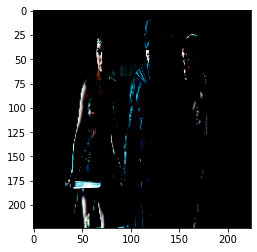

In [ ]:
#Printing sample image and image array
n = 15
print(X_train[n])
plt.imshow(X_train[n])

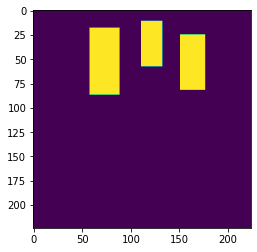

In [ ]:
plt.imshow(masks[n])

### **1.3. Creating Face Mask detection model**

*   Designing face mask detection model using MobileNet and U-Net 
> MobileNet parameter values : Input_shape:IMAGE_HEIGHT, IMAGE_WIDTH, 3; include_top: False; alpha: 1.0; weights: "imagenet"
*   Designing Dice Coefficient and Loss function
*   Training and Testing the model
*   Evaluating the model using testing data


In [ ]:
def create_model(trainable = True):
    IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    model = MobileNet(input_shape = IMG_SHAPE, alpha = 1.0, include_top = False, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block0 = model.get_layer('conv_pw_1_relu').output
    block1 = model.get_layer('conv_pw_3_relu').output
    block2 = model.get_layer('conv_pw_5_relu').output
    block3 = model.get_layer('conv_pw_11_relu').output
    block4 = model.get_layer('conv_pw_13_relu').output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size = 1, activation = "sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs = model.input, outputs = x)

In [ ]:
# calling create_model function
model = create_model()

# Print summary
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

**Defining Dice Coefficient**

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

**Defining loss**

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

**Compiling model**

In [ ]:
# Compiling the model using optimizer as Adam, loss = Binary crossentropy, metrics = Dice Coefficient
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
#Defining checkpoint and early stopping
#checkpoint = ModelCheckpoint(filepath=project_path + 'saved_models/model-{loss:.2f}.h5', monitor="loss", verbose=1, save_best_only=True,
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")


In [ ]:
#Fitting the model
model.fit(X_train, masks, epochs = 10, batch_size = 1, validation_split = 0.1,  #splitting 10% of data into validation set          
                    callbacks = [checkpoint, reduce_lr, stop],
                    workers = 8,
                    use_multiprocessing = True,                    
                    verbose = 1)

Streaming output truncated to the last 5000 lines.
Epoch 00004: loss did not improve from 0.25004
 84/368 [=====>........................] - ETA: 5:52 - loss: 0.6204 - dice_coefficient: 0.6906
Epoch 00004: loss did not improve from 0.25004
 85/368 [=====>........................] - ETA: 5:51 - loss: 0.6216 - dice_coefficient: 0.6905
Epoch 00004: loss did not improve from 0.25004
 86/368 [======>.......................] - ETA: 5:49 - loss: 0.6228 - dice_coefficient: 0.6904
Epoch 00004: loss did not improve from 0.25004
 87/368 [======>.......................] - ETA: 5:48 - loss: 0.6240 - dice_coefficient: 0.6903
Epoch 00004: loss did not improve from 0.25004
 88/368 [======>.......................] - ETA: 5:46 - loss: 0.6251 - dice_coefficient: 0.6902
Epoch 00004: loss did not improve from 0.25004
 89/368 [======>.......................] - ETA: 5:45 - loss: 0.6262 - dice_coefficient: 0.6901
Epoch 00004: loss did not improve from 0.25004
 90/368 [======>.......................] - ETA: 5:

In [ ]:
model.save(project_path+'model-0.16.h5')


In [ ]:
#Loading the weights of the model
model.load_weights(project_path+'model-0.16.h5')

**Evaluating model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


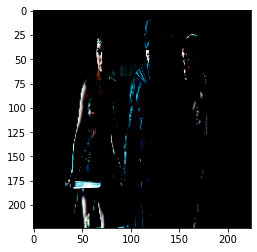

In [ ]:
# Getting sample image
n = 15
sample_image = X_train[n]
final_image = sample_image
print(sample_image.shape)
plt.imshow(sample_image)

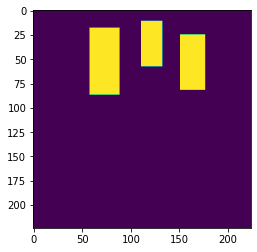

In [ ]:
# Getting sample mask
n = 15
sample_mask = masks[n]
final_mask = sample_mask
plt.imshow(sample_mask)

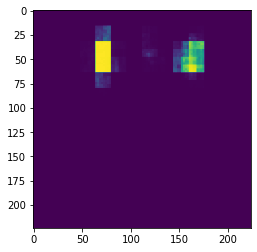

In [ ]:
# Predicted mask
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
plt.imshow(pred_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


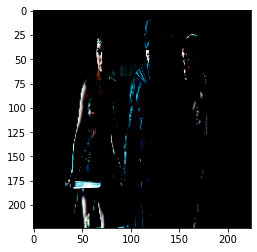

In [ ]:
# Imposing mask on the image
final_pred_mask = np.resize(pred_mask, (224, 224))
final_image = np.resize(sample_image, (224, 224, 3))
plt.imshow(final_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


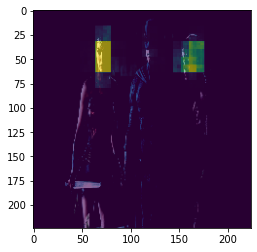

In [ ]:
# Mask imposed image
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha = 0.6)
plt.show()

### **1.4. Using the “Prediction image” as an input to the model and displaying the output of the image**

(224, 224, 3)


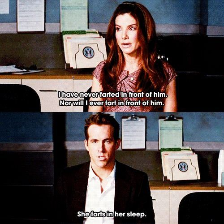

In [ ]:
# Getting sample image
from google.colab.patches import cv2_imshow
img = cv2.imread(project_path + 'PredictionImage.jpeg')
sample_image = cv2.resize(img, dsize = (224,224))
final_image = sample_image
print(sample_image.shape)
cv2_imshow(sample_image)

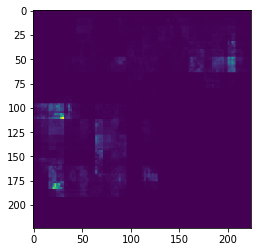

In [ ]:
# Predicted mask
sample_image = np.resize(sample_image, (1, 224, 224, 3))
pred_mask = model.predict(x = sample_image)
pred_mask = np.resize(pred_mask, (224, 224))
plt.imshow(pred_mask)

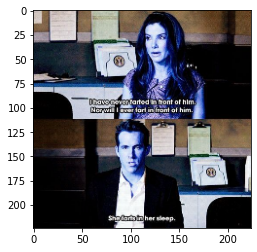

In [ ]:
# Imposing mask on the image
final_pred_mask = np.resize(pred_mask, (224, 224))
final_image = np.resize(sample_image, (224, 224, 3))
plt.imshow(final_image)

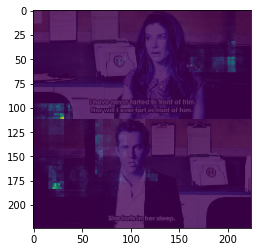

In [ ]:
# Mask imposed image
fig = plt.figure()
img_1 = plt.imshow(final_image)
img_2 = plt.imshow(final_pred_mask, alpha =0.8)
plt.show()

**PART-1 - Conclusion:**

The pretrained MobileNet is used (Transfer Learning) and on top of it UNET layers are added to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image
*   Model was compiled using binary cross entropy as loss function, adam optimizer and dice coefficient as metric.
*   Data was split into train and validation using 90/10 ratio.
* Thus, face detection model has been built and used for predicting the mask


## **PART-3 - Objective:**
The objective is to use a pre-trained model trained on Face Recognition to recognize similar faces and also to recognize whether two given faces are of the same person or not.

### **3.1. Loading the Aligned Face Dataset from Pinterest and creating the metadata**

In [ ]:
# Extracting the Aligned Face Dataset from Pinterest.zip
train_images = project_path+'Aligned Face Dataset from Pinterest.zip'

In [ ]:
import zipfile
archive = zipfile.ZipFile(train_images, 'r')
archive.extractall()

In [ ]:
# Defining the function to load the images from the extracted folder and map each image with person id
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [ ]:
# Defining a function to load image from the metadata
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels in BGR order. Order of images are reversed
    return img[...,::-1]

### **3.2. Loading sample images from metadata**

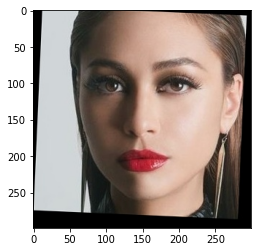

In [ ]:
img_1 = load_image(metadata[10].image_path())
plt.imshow(img_1)

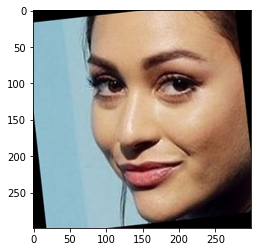

In [ ]:
img_1 = load_image(metadata[20].image_path())
plt.imshow(img_1)

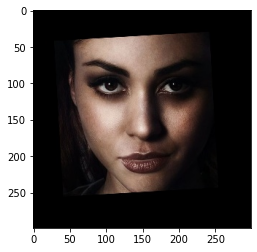

In [ ]:
img_1 = load_image(metadata[30].image_path())
plt.imshow(img_1)

### **3.3. Loading the VGG Face model (pre-trained model) and weights**

In [ ]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1, 1),  input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
#Loading the VGG Face model and weights
model = vgg_face()
model.save(project_path+'vgg_face_weights.h5')

In [ ]:
model.load_weights(project_path+'vgg_face_weights.h5')

In [ ]:
# Get VGG face descriptor
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs = model.layers[-2].output)

**3.4.Generate Embedding vectors for each face in the dataset**

In [ ]:
#Loading the first image in the metadata and get its embedding vector from the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [ ]:
# Generate Embedding vectors for each face in the dataset
# 1. iterating through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings
# 2. If there is any error in reading any image in the dataset, filling the embedding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.
embeddings = np.zeros((metadata.shape[0], 2622))

for i in range(len(metadata)):
    img_path = metadata[i].image_path()
    print(i, metadata[i])
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224, 224))
    
    #obtaining embedding vectors of all images
    embedding_vectors = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
    embeddings[i] = embedding_vectors

Streaming output truncated to the last 5000 lines.
5770 PINS/pins_bellamy blake face/bellamy blake face61.jpg
5771 PINS/pins_bellamy blake face/bellamy blake face15.jpg
5772 PINS/pins_bellamy blake face/bellamy blake face25.jpg
5773 PINS/pins_bellamy blake face/bellamy blake face69.jpg
5774 PINS/pins_bellamy blake face/bellamy blake face11.jpg
5775 PINS/pins_bellamy blake face/bellamy blake face54.jpg
5776 PINS/pins_bellamy blake face/bellamy blake face21.jpg
5777 PINS/pins_bellamy blake face/bellamy blake face40.jpg
5778 PINS/pins_bellamy blake face/bellamy blake face38.jpg
5779 PINS/pins_bellamy blake face/bellamy blake face49.jpg
5780 PINS/pins_bellamy blake face/bellamy blake face14.jpg
5781 PINS/pins_bellamy blake face/bellamy blake face24.jpg
5782 PINS/pins_bellamy blake face/bellamy blake face64.jpg
5783 PINS/pins_bellamy blake face/bellamy blake face45.jpg
5784 PINS/pins_bellamy blake face/bellamy blake face39.jpg
5785 PINS/pins_bellamy blake face/bellamy blake face81.jpg
5786 

### **3.5. Building distance metrics for identifying the distance between two given images**

In [ ]:
# Distance Metric is : "Squared L2 distance"
# Squared L2 distance between 2 points (x1, y1) and (x2, y2) is calculated using the formula = (x1-x2)^2 + (y1-y2)^2
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

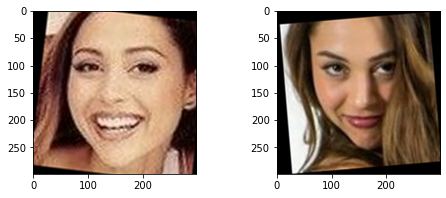

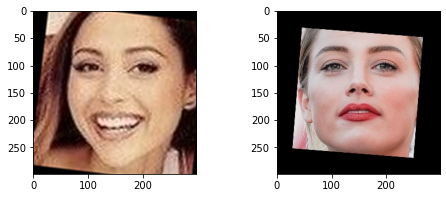

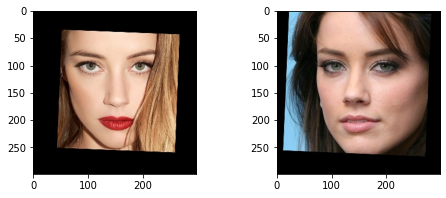

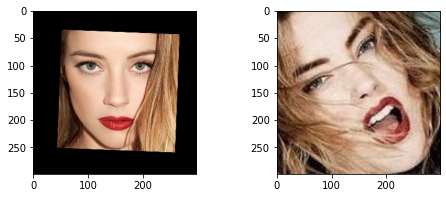

In [ ]:
# Plot images and get distance between the pairs - [2, 3 and 2, 140],  [80, 82 and 80, 115]
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
   # plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 140)

show_pair(80, 82)
show_pair(80, 115)


 **Observation:**
From the above, the similar images have less distance while the dissimilar images have greater distance

**Preprocessing Train & Test sets**

In [ ]:
# Creating train and test sets
# 1. Creating X_train, X_test and y_train, y_test
# 2. Using train_idx to seperate out training features and labels
# 3. Using test_idx to seperate out testing features and labels
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

In [ ]:
# Encoding target labels
from sklearn.preprocessing import LabelEncoder

target = np.array([m.name for m in metadata])
enc = LabelEncoder()
enc.fit(target)

y = enc.transform(target)
y_train = y[train_idx]
y_test = y[test_idx]

In [ ]:
#scaling the features using standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### **3.6. Using PCA for dimensionality reduction**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA() 
  
X_train = pca.fit_transform(X_train_scaled) 
X_test = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[2.62182945e-01 1.15466246e-01 1.00221836e-01 ... 5.30957960e-08
 5.28665589e-08 5.01643122e-08]


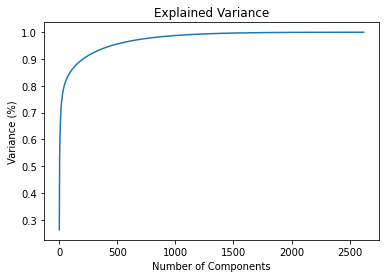

In [ ]:
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

**Observation:**
As we can see from the above plot that approximately 1300 components explain close to 98% variance, we can reduce the number of components to 1300 in order to save the computational power without compromising much on the accuracy.

In [ ]:
pca = PCA(n_components = 1300) 
  
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_ 
print(explained_variance)

[2.62182945e-01 1.15466246e-01 1.00221836e-01 ... 1.38270421e-05
 1.37122862e-05 1.36481588e-05]


### **3.7. Building an SVM classifier to map each image to its right person**

In [ ]:
from sklearn.svm import SVC
svc = SVC(C = 1.0, kernel = 'rbf', gamma = 'scale')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

### **3.8. Predicting faces using SVM model**

Text(0.5, 1.0, 'Identified as pins_Amanda Crew')

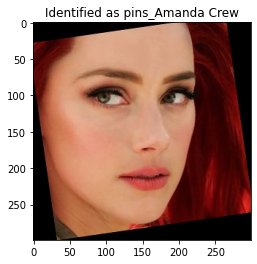

In [ ]:
example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())

#transforming the embedding of the 10th image
example_prediction = svc.predict([X_test[example_idx]])

#inverse transformation of the 10th image
example_identity = enc.inverse_transform(example_prediction)[0]

plt.imshow(example_image)

#the image belongs to which person
plt.title(f'Identified as {example_identity}')

The image belongs to Amanda Crew

**PART-3 - Conclusion:**

Recognizing (aligned) faces from a Pinterest dataset containing 10k+ images for 100 people using a pre-trained model on Face Recognition is done
*   VGG model with pre-trained weights was used to generate embeddings for each images in the dataset.
*   Distance between two pair of images were also calculated and plotted
*   Since, there were 2,622 features for each image, PCA was used for dimensionality reduction after standardizing the features.
*   With an cumulative explained variance of 98%, 1200 PCA components were used
*   Using SVC, predicted the labels for test dataset 







## **PART-4**
Objective is to create an automation using computer vision to impute dynamic bounding boxes to locate cars or vehicles on the given video files

In [ ]:
#Import libraries
import os
import re
import cv2 # opencv library
import numpy as np
from os.path import isfile, join
import matplotlib.pyplot as plt

In [ ]:
#Importing input video frames stored in "frames" folder in google colab

# get file names of the frames
col_frames = os.listdir('/content/drive/My Drive/AIML/Projects/CV2/frames/')

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
col_images=[]

for i in col_frames:
    # read the frames
    img = cv2.imread('/content/drive/My Drive/AIML/Projects/CV2/frames/'+i)
    # append the frames to the list
    col_images.append(img)
print(col_frames)  

['0.png', '1.png', '2.png', '3.png', '7.png', '8.png', '9.png', '13.png', '14.png', '15.png', '19.png', '20.png', '21.png', '25.png', '26.png', '27.png', '31.png', '32.png', '33.png', '37.png', '38.png', '39.png', '43.png', '44.png', '48.png', '49.png', '50.png', '51.png', '55.png', '56.png', '57.png', '61.png', '62.png', '63.png', '67.png', '68.png', '72.png', '73.png', '74.png', '78.png', '79.png', '80.png', '81.png', '85.png', '86.png', '87.png', '91.png', '92.png', '96.png', '97.png', '98.png', '102.png', '103.png', '104.png', '105.png', '109.png', '110.png', '114.png', '115.png', '116.png', '120.png', '121.png', '122.png', '123.png', '127.png', '128.png', '132.png', '133.png', '134.png', '135.png', '139.png', '140.png', '141.png', '145.png', '146.png', '150.png', '151.png', '152.png', '156.png', '157.png', '158.png', '162.png', '163.png', '164.png', '168.png', '169.png', '170.png', '171.png', '175.png', '176.png', '177.png', '181.png', '182.png', '186.png', '187.png', '188.png', '

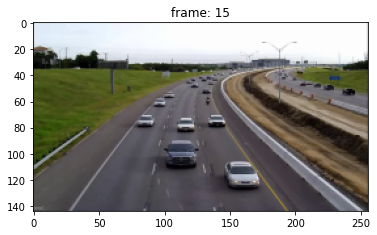

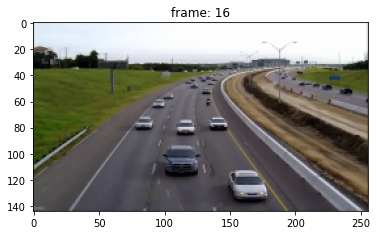

In [ ]:
# Data Exploration - Displaying two consecutive frames
# plot 15th frame and 16th frame
i = 15

for frame in [i, i+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title("frame: "+str(frame))
    plt.show()

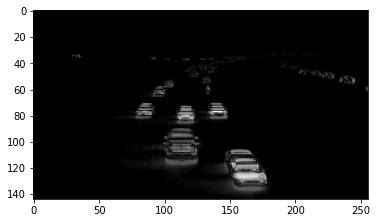

In [ ]:
# converting the frames to grayscale - It is hard to find any difference in these two frames, taking the difference of the pixel values of two consecutive frames will help to observe the moving objects
grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

# ploting the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

The moving objects can be seen clearly in the 15th and 16th frames. Everything else that was not moving has been subtracted out.

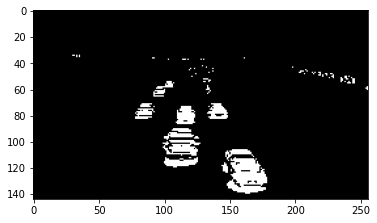

In [ ]:
#Image Preprocessing - applying thresholding to the above image
diff_image = cv2.absdiff(grayB, grayA)

# performing image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# ploting image after thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

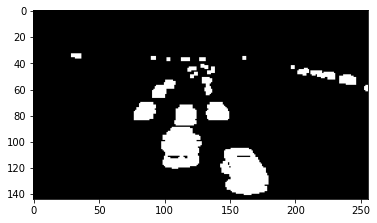

In [ ]:
# applying image dilation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh,kernel,iterations = 1)

# ploting dilated image
plt.imshow(dilated, cmap = 'gray')
plt.show()

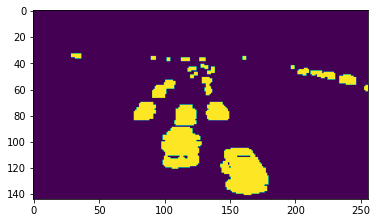

In [ ]:
# ploting vehicle detection zone
plt.imshow(dilated)
cv2.line(dilated, (0, 80),(256,80),(100, 0, 0))
plt.show()

In [ ]:
#The area below the horizontal line y = 80 is the vehicle detection zone. will detect any movement that happens in this zone only. 
# find contours- finds all the contours in the entire image and keeps them in the variable ‘contours’
contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

In [ ]:
valid_cntrs = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

7

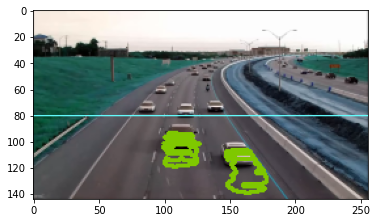

In [ ]:
#ploting the contours along with the original frame
dmy = col_images[13].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
plt.imshow(dmy)
plt.show()

**Vehicle Detection in Videos:**

applying  the same image transformations and pre-processing operations on all the frames and find the desired contours. Below steps are followed:
1. Applying frame differencing on every pair of consecutive frames
2. Applying image thresholding on the output image of the previous step
3. Performing image dilation on the output image of the previous step
4. Finding contours in the output image of the previous step
5. Shortlisting contours appearing in the detection zone
6. Finally, Saving frames along with the final contours


In [ ]:
# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = "/content/drive/My Drive/AIML/Projects/CV2/contour_frames_3/"

for i in range(len(col_images)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            if (y >= 90) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    cv2.line(dmy, (0, 80),(256,80),(100, 255, 255))
    cv2.imwrite(pathIn+str(i)+'.png',dmy)  

Contours for all the moving vehicles in all the frames have been added. Video is created by stacking up the frames


In [ ]:
# specify video name
pathOut = '/content/drive/My Drive/AIML/Projects/CV2/vehicle_detection_v3.mp4'

# specify frames per second
fps = 14.0

In [ ]:
# Creating final frames in the list
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

In [ ]:
files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename=pathIn + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

In [ ]:
# Creating object detection video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()

Thus, Dynamic bounding boxes are imputed over live video - vehicle_detection_v3.mp4

## **PART-2 :**
To perform below tasks as part of creating image dataset to build an image classifier data:
1. To curate the bounding box co-ordinates for each training image provided
2. To do an automation to output bounding box coordinates of the face detected from each of training images and to comment on challenges faced in this task


In [ ]:
#Importing first 25 training images provided as part of dataset -real and fake face detection

# get file names of training files
file_names = os.listdir('/content/drive/My Drive/AIML/Projects/CV2/training_images/')

# sort file names
file_names.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store training images
#col_images=[]

for i in file_names:
    # read the images
    img = cv2.imread('/content/drive/My Drive/AIML/Projects/CV2/training_images/'+i)
    # append the training images to the list
    #col_images.append(img)
print(file_names)  

['real_00001.jpg', 'real_00002.jpg', 'real_00003.jpg', 'real_00004.jpg', 'real_00005.jpg', 'real_00006.jpg', 'real_00007.jpg', 'real_00008.jpg', 'real_00009.jpg', 'real_00010.jpg', 'real_00011.jpg', 'real_00012.jpg', 'real_00013.jpg', 'real_00014.jpg', 'real_00015.jpg', 'real_00016.jpg', 'real_00017.jpg', 'real_00018.jpg', 'real_00019.jpg', 'real_00020.jpg', 'real_00021.jpg', 'real_00022.jpg', 'real_00023.jpg', 'real_00024.jpg', 'real_00025.jpg']


In [ ]:
# importing training images & annotation xml data
from os import listdir
from os.path import join, isfile
import shutil
import os, sys, random
import xml.etree.ElementTree as ET
from PIL import Image
import requests
import urllib

annotPath='/content/drive/My Drive/AIML/Projects/CV2/maskDetectorXMLfiles/'

data=pd.DataFrame(columns=['fileName','x','y','w','h','class'])

os.getcwd()
#read All files
allfiles = [f for f in listdir(annotPath) if isfile(join(annotPath, f))]

In [ ]:
for file in allfiles:

  if (file.split(".")[1]=='xml'):

    fileName='/content/drive/My Drive/AIML/Projects/CV2/maskDetectorXMLfiles/'+file.replace(".xml",'.jpg')
    tree = ET.parse(annotPath+file)
    root = tree.getroot()
    for obj in root.iter('object'):
            cls_name = obj.find('name').text
            xml_box = obj.find('bndbox')
            
            x = xml_box.find('xmin').text
            y = xml_box.find('ymin').text
            w = xml_box.find('xmax').text
            h = xml_box.find('ymax').text

            # Append rows in the Dataframe
            data = data.append({'fileName': fileName, 'x': x, 'y':y,'w':w,'h':h,'class':cls_name}, ignore_index=True)

data.shape

(26, 6)

In [ ]:
#Output bounding box coordinates of the face detected from each of 25 training images
data

,fileName,x,y,w,h,class
0,/content/drive/My Drive/AIML/Projects/CV2/mask...,1,4,600,593,person
1,/content/drive/My Drive/AIML/Projects/CV2/mask...,5,4,539,593,person
2,/content/drive/My Drive/AIML/Projects/CV2/mask...,91,23,550,585,person
3,/content/drive/My Drive/AIML/Projects/CV2/mask...,90,27,570,583,person
4,/content/drive/My Drive/AIML/Projects/CV2/mask...,86,7,499,574,person
5,/content/drive/My Drive/AIML/Projects/CV2/mask...,125,6,526,567,person
6,/content/drive/My Drive/AIML/Projects/CV2/mask...,23,9,600,584,person
7,/content/drive/My Drive/AIML/Projects/CV2/mask...,4,3,548,574,person
8,/content/drive/My Drive/AIML/Projects/CV2/mask...,89,4,499,575,person
9,/content/drive/My Drive/AIML/Projects/CV2/mask...,1,1,520,574,person


**Below Challenges were faced for doing automation to output bounding box coordinates of the face detected from training images**

1. Created annotation xmls for 25 images in training dataset provided using the tool "LabelImg". The challenge is each of the images has to be opened in the LabelImg tool and bounding boxes had to be drawn manually which is a cumbersome process. Though auto mode is available in the tool, it took nearly 30 minutes for 25 images to create annotation xmls using auto mode.

2. Then, using above python code,  annotations xml data have been imported and bounding box coordinates for each of the face detected from 25 training images were added to dataframe and output is shown